# RO47002 Machine Learning for Robotics
* (c) TU Delft, 2024
* Period: 2024-2025, Q1
* Course homepage: https://brightspace.tudelft.nl/d2l/home/682421

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Moreover, if you see an empty cell, please DO NOT delete it, instead run that cell as you would run all other cells. Please fill in your name(s) and other required details below:

In [64]:
GROUP_NUMBER = "54"
STUDENT_NAME1 = "Nathan Blum"
STUDENT_NUMBER1 = "5134293"
STUDENT_NAME2 = ""
STUDENT_NUMBER2 = ""

In [65]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert(GROUP_NUMBER != "")
assert(STUDENT_NAME1 != "")
assert(STUDENT_NUMBER1 != "")
assert(STUDENT_NAME2 != "")
assert(STUDENT_NUMBER2 != "")

AssertionError: 

### General announcements

* Do *not* share your solutions, and do *not* copy solutions from others. By submitting your solutions, you claim that you and your lab partner alone are responsible for this code.

* Do *not* email questions directly, since we want to provide everybody with the same information and avoid repeating the same answers. Instead, please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. If you do have a particular question that you want to ask directly, please use the scheduled practicum hours to ask a TA.

* There is a strict deadline for each assignment. Students are responsible to ensure that they have uploaded their work in time. So, please double check that your upload succeeded to the Brightspace and avoid any late penalties.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. You are free to add additional cells, but if you find a cell that you cannot modify or remove, please know that this is on purpose.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for youthat you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

---

# Practicum 5

* Topics: Dimensionality reduction, clustering
* Before performing this practicum, work through **Book chapter(s): 8, 9**
* **Deadline**: Monday, October 7, 2024, 23:59


## Objectives

* This lab assignment consists of two parts:

### Part 1 - Dimensionality Reduction
* Understanding Principal Component Analysis (PCA) transformations using on a 3D toy dataset
* Implementing PCA project and reconstruction yourself
* Using PCA for data compression
* Using PCA on a real Pedestrian image dataset, and computing the "Eigen-Pedestrians"

### Part 2 - Clustering
* Using K-Means on a toy dataset
* Implementing the basic K-Means algorithm yourself
* Using a Gaussian Mixture Model (GMM) for clustering
* Comparing K-Means and GMM for outlier detection
* Application: *Meeting and recognizing human faces*
* A simple semi-supervised approach to improve clustering

# Part 1

### Setup common python stuff
We will start by loading a few common python dependencies

In [66]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
#%matplotlib inline
import matplotlib as mpl
print(mpl.__version__)
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

3.9.2


In [67]:
import ipywidgets
from IPython.display import display

## 1.1 PCA on 3D Toy Data

We will first create a small 3D "toy" dataset to investigate PCA as a dimensionality reduction technique.
We'll  treat this data just as samples from some distribution over the 3D feaure space.

For now, we will not consider that different samples have different class labels.
There could be various reasons why we would want to consider PCA to consider such a data distribution. For instance:
- These could all be samples from the same class and we want to understand how to model the class-conditional distribution in a Bayesian classifier.
- We might know that these will be samples from mulitple classes, but we just do not know the class labels yet (maybe these still need to be annotated) but sill wish to compress the dataset size.
- We might want to create a 2D plot of the samples, so we can get an intuition of the data in the higher dimensional space. E.g. maybe we can already determine if the classes are easily separable or not, and how their data is distributed (e.g. is the distribution skewed, symmetric, uncorrelated, etc.). A word of caution though: if the classes are easily separable in the 2D plot after a linear projection, they'll also be seperable by a linear classifier in the original higher dimensional space; However if they are not easily separable in 2D space, they could be seperable in a 2+ dimensional space, so this doesn't give a definitive answer.

Our goal here is to use understand how PCA preserves the variance of the data by projecting to a lower dimensional space, and how we can perform the inverse projection from this projection back to the original 3D space to reconstruct the original data.

### 1.1.1 Create and explore the 3D toy dataset

The block below creates the dataset.

In [68]:
from sklearn import datasets

X, y = datasets.load_iris(return_X_y=True)
mask = (y != 0)
X = X[mask,:]
y = y[mask]

# make data a bit more interesting
X = X[:,:3] # only use 3 dimensions
X[:,1] *= 0.3 # scale down 2nd dimension
X[:,0] += X[:,1] * 0.8
X[:,2] *= 1.5

y = (y == 2).astype(int)

How could you determine which features are correlated, and what features contain most of the variance in the data? One way is to compute and report some statistics on the features.

Use the code block below to compute the variance of each feature.

In [69]:
# Compute the variance of each feature, and print them to the output for instance.
# You'll use the result to answer the question in the next code block.

# YOUR CODE HERE

var0 = np.var(X[0])
var1 = np.var(X[1])
var2 = np.var(X[2])

print(var0, var1, var2)
print()

cov = np.cov(X.T)

print(cov)


9.328054222222223 8.026454222222222 9.597848

[[0.50436279 0.04461935 0.73144897]
 [0.04461935 0.00996509 0.06425818]
 [0.73144897 0.06425818 1.53355455]]


Based on your calculations, order the 3 features from most to least variance.

Use the variable `FEATURE_ORDER_MOST_TO_LEAST_VARIANCE` to give your answer by listing the feature dimensions (0, 1, 2) in order of decreasing variance.
For instance, if you answer that feature 0 has most variance, feature 1 the second most, and feature 2 the least variance, answer: `FEATURE_ORDER_MOST_TO_LEAST_VARIANCE = [0, 1, 2]`

In [70]:
# replace the -1s here and put the numbers 0, 1, 2 in the right order
FEATURE_ORDER_MOST_TO_LEAST_VARIANCE = [2, 0, 1]

# YOUR CODE HERE


In [71]:
# ensure all numbers 0, 1, 2 occur once in your answer
assert(len(FEATURE_ORDER_MOST_TO_LEAST_VARIANCE) == 3)
assert(np.all(np.bincount(FEATURE_ORDER_MOST_TO_LEAST_VARIANCE) == [1,1,1]))


The statistics are useful, but don't show the structure of the samples directly.

Since this is a 3D dataset, we can also try to visualize all 3 features at once in a 3D plot
which can be rotated around to better understandin the underlying structure.
The provided code below sets up the [3D plotting interface of matplotlib](https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html), and uses the ipython widgets to allow you to adapt the viewing angle and see the data from different perspectives.

In [72]:
from mpl_toolkits.mplot3d import axes3d

def make_3d_plot_axes_equal(ax):
    """ Utility function to make axes equally scaled for 3D plots in matplotlib.
        Note that for 2D plots we can simply use ax.axes('equal'),
        but unfortunately this doesn't work for 3D plots, so we use this utility function.
        
        Inspired by: https://stackoverflow.com/a/31364297
    """ 
    
    ax_limits = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()]).T
    
    m = ax_limits.mean(axis=0)
    max_range = (ax_limits - m).max();
    
    ax.set_xlim(m[0] - max_range, m[0] + max_range)
    ax.set_ylim(m[1] - max_range, m[1] + max_range)
    ax.set_zlim(m[2] - max_range, m[2] + max_range)
    

def plot_3d_data(X, view_angle1, view_angle2, label_name='dim'):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111, projection='3d')

    ax.view_init(view_angle1, view_angle2)
    
    ax.scatter(X[:,0], X[:,1], X[:,2], s=5., alpha=0.7)

    plt.xlabel(label_name+' 0')
    plt.ylabel(label_name+' 1')
    ax.zaxis.set_label_text(label_name+' 2') # no plt.zlabel() :-/

    # ensure 3D plot has equally scaled axes
    make_3d_plot_axes_equal(ax)

    plt.show()


# make rotatable 3D plot with standard plotting tools
ipywidgets.interactive(
    lambda view_angle1, view_angle2: plot_3d_data(X, view_angle1, view_angle2, label_name='feature'),
    view_angle1=(0, 90),
    view_angle2=(0, 360)
)

interactive(children=(IntSlider(value=45, description='view_angle1', max=90), IntSlider(value=180, description…

The 3D plot allows us to get a good feeling of how the data is distributed in the space, but it can be hard to really read off particular feature values for any sample.
Alternatively, we could have projected the 3D to a 2D plane by only plotting 2 feature dimensions at once, ignoring the third. With 3 features, there are 3 possible feature combinations to plot:

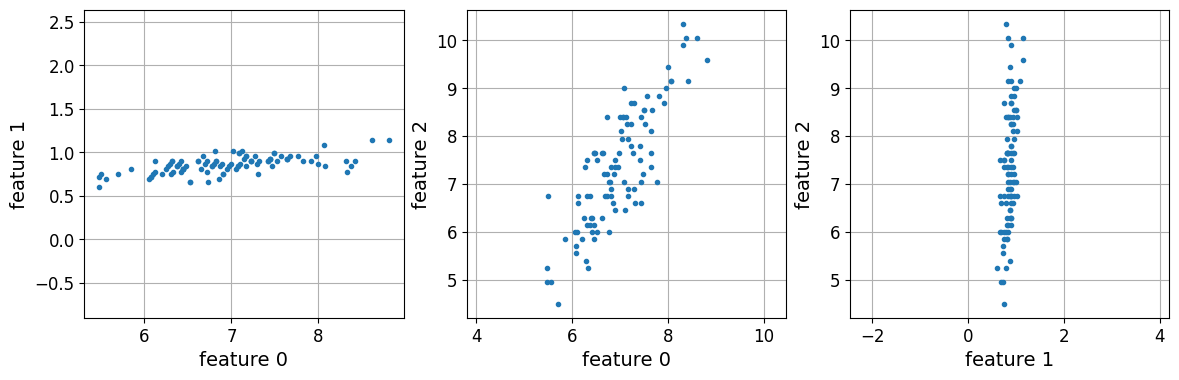

In [73]:
def plot_data_on_axes(X, feat_hor, feat_ver):
    plt.plot(X[:, feat_hor], X[:, feat_ver], '.')
    plt.xlabel(f'feature {feat_hor}')
    plt.ylabel(f'feature {feat_ver}')
    plt.axis('equal')
    plt.grid('on')

def plot_axis_combinations(X):
    plt.subplot(1,3,1)
    plot_data_on_axes(X, feat_hor=0, feat_ver=1)
    
    plt.subplot(1,3,2)
    plot_data_on_axes(X, feat_hor=0, feat_ver=2)

    plt.subplot(1,3,3)
    plot_data_on_axes(X, feat_hor=1, feat_ver=2)
    
plt.figure(figsize=(14,4))
plot_axis_combinations(X)

**Q**: Based on these plots, which of these feature pairs are most strongly correlated?

Answer in the code block below.

In [74]:
# replace the -1s here by the indices (0, 1 or 2) of the two strongest correlated features
#   NOTE: order doesn't matter for this answer
MOST_STRONLGY_CORRELATED_FEATURE_PAIR = (0, 2)


In [75]:
assert(len(MOST_STRONLGY_CORRELATED_FEATURE_PAIR) == 2)
assert(MOST_STRONLGY_CORRELATED_FEATURE_PAIR[0] in (0,1,2))
assert(MOST_STRONLGY_CORRELATED_FEATURE_PAIR[1] in (0,1,2))


### 1.1.2 Transforming the data with Principal Component Analysis

The 2D plots give a better picture of the statstical relation between feature pairs, but all of them give you an incomplete picture because they ignore some aspects of the data. With higher dimensional data, there are many more possible feature combinations to explore. And, we can't plot all features in an interactive plot for more the 3 dimensions either.

PCA allows us to find a linear transformation of the data, i.e. by performing a PCA projection we create a  transformed dataset where each feature is a linear combination of the original features.
In the projected representation, the first dimension will capture most of the data variance, and the last dimension the least amount of variance.

By only keeping the first few PCA dimensions, we can thus reduce high dimensional data to a smaller number of dimensions which still contain as much variations in the data as possibly could be kept with a linear transformation.

Use sklearn's PCA implementation to fit and transform the data $X$.
For now, just use the default PCA options, don't set any keywords in the constructor.

Remember that most of the intuition and basic usage of sklearn's PCA have been explained in Chapter 8 of the book.

In [76]:
pca = None # store the PCA estimator, we need it later on.
X_pca = None # store the result of the PCA projection of X in this variable

from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)




In [77]:
assert(X_pca.shape == (100, 3)) # 100 samples, 3 dimensions after projection
assert(not pca is None)
assert(pca.__class__.__name__ == 'PCA')


As we did with the original data features, determine again how much variance there is in each of the 3 dimensions after PCA transformation, and order these dimensions from most to least variance.

In [78]:
# replace the -1s here and put the numbers 0, 1, 2 in the right order
# PCA_PROJ_ORDER_MOST_TO_LEAST_VARIANCE = [-1, -1, -1]

var0_pca = np.var(X_pca[0])
var1_pca = np.var(X_pca[1])
var2_pca = np.var(X_pca[2])

print(var0_pca, var1_pca, var2_pca)

PCA_PROJ_ORDER_MOST_TO_LEAST_VARIANCE = [0, 2, 1]

0.18858104382696209 0.0328469968231831 0.15078538244631876


In [79]:
# ensure all numbers 0, 1, 2 occur once in your answer
assert(len(PCA_PROJ_ORDER_MOST_TO_LEAST_VARIANCE) == 3)
assert(np.all(np.bincount(PCA_PROJ_ORDER_MOST_TO_LEAST_VARIANCE) == [1,1,1]))


The data after the PCA project still has 3 dimensions. Therefore, we can again visualize the data using 3D or 2D plots, like before.

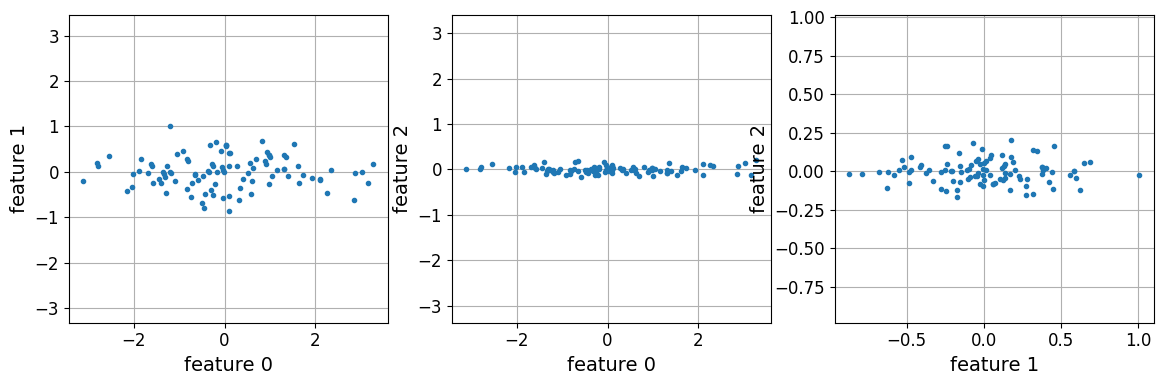

interactive(children=(IntSlider(value=45, description='view_angle1', max=90), IntSlider(value=180, description…

In [80]:
plt.figure(figsize=(14,4))
plot_axis_combinations(X_pca)

# Note: using X_pca here
ipywidgets.interactive(
    lambda view_angle1, view_angle2: plot_3d_data(X_pca, view_angle1, view_angle2, label_name='PCA proj.'),
    view_angle1=(0, 90),
    view_angle2=(0, 360)
)


Notice how the order and variance of each dimension after PCA projection is different from those of the original 3 feature dimensions (compare the data statistics here to those of the original data).

### 1.1.3 Visualizing the PCA components

The PCA object has computed two important statistics,
the `mean` of the data in the feature space,
and the `principal components`.
The principal components define a new *orthonormal basis* in the original feature space,
located around the mean of the data.
An orthonormal basis means that the basis vectors are
1. all perpendicular to eachother
2. all have unit length

We can therefore regard it as a translation of the original feature, to subtract the mean, plus a rotation (and possibly with mirroring of some axes, which would just swap the sign in one of the dimensions).

Let's visualize the mean and principal components in the original feature space:

In [81]:
def plot_3d_pca_components(pca, X, view_angle1, view_angle2, label_name='dim'):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111, projection='3d')

    # set view angle
    ax.view_init(view_angle1, view_angle2)

    # plot data
    ax.scatter(X[:,0], X[:,1], X[:,2], s=5., alpha=0.3)

    # get the data mean (a 3D vector) from the pca object, and plot it as star
    m = pca.mean_
    ax.plot((m[0],), (m[1],), (m[2],), 'k*', label='mean')
    
    # get each of the 3 pca components from the pca object, and plot it as a vector from the mean
    for c in range(pca.components_.shape[0]):
        comp = pca.components_[c]
        color = 'rgb'[c]
        p1 = m + comp
        ax.plot((m[0], p1[0]), (m[1], p1[1]), (m[2], p1[2]), color+'-', label=f'PCA comp. {c}')
    
    # give all the axes a nice name
    plt.xlabel(label_name+' 0')
    plt.ylabel(label_name+' 1')
    ax.zaxis.set_label_text(label_name+' 2') # no plt.zlabel() :-/
    
    # ensure 3D plot has equally scaled axes
    make_3d_plot_axes_equal(ax)

    plt.legend()
    plt.show()


# make rotatable 3D plot with standard plotting tools
ipywidgets.interactive(
    lambda view_angle1, view_angle2: plot_3d_pca_components(pca, X, view_angle1, view_angle2, label_name='feature'),
    view_angle1=(0, 90),
    view_angle2=(0, 360)
)

interactive(children=(IntSlider(value=45, description='view_angle1', max=90), IntSlider(value=180, description…

Let's implement some tests to show that the computed PCA components (`pca.components_`) indeed form an orthonormal basis. That is

1. complete the function `component_is_unit_length(component)` which only returns True if the given vector `component` has unit length, and returns False otherwise.

2. complete the function `components_are_orthogonal(comp1, comp2)` which only returns True if the two given vectors `comp1` and `comp2` are perpendicular to each other (*Hint*: what should the dot product of two perpendicular vectors be?)

We'll then apply your functions to all PCA components and pairs of components.
Note that for these tests you always need to allow for some small tolerance for small deviations of the desired outout, e.g. in the order of 10^-3 . The calculations of the computer have finite precision, so computed the length vector of a unit vector might actually be 1.000001, for instance.

In [82]:
def component_is_unit_length(component):
    """ Test if the length of a given component is 1.0
        NOTE: you can allow some tolerance to numeric imprecision,
        e.g. you can return True if the length l is between (0.999) < l < (1.001)
        
        Input: component - a vector
        Output: is_unit_length - a boolean (True or False)
    """
    sqrd = 0
    is_unit_length = False
    for i in component: sqrd += i*i
    if np.sqrt(sqrd) > 0.999 and np.sqrt(sqrd) < 1.001:
        is_unit_length = True
    return is_unit_length

def components_are_orthogonal(comp1, comp2):
    """ Test two components are orthogonal.
        NOTE: As in component_is_unit_length(), some tolerance to numeric imprecision is allowed
        
        Input: comp1 - a vector
        Input: comp2 - a vector
        Output: are_orthogonal - a boolean (True or False)
    """
    are_orthogonal = False
    if comp1.dot(comp2) > -0.001 and comp1.dot(comp2) < 0.001:
        are_orthogonal = True
    return are_orthogonal

In [83]:
# Test if each of the 3 PCA components have unit length
for j in range(3):
    comp = pca.components_[j]
    
    # your function is called here
    is_unit_length = component_is_unit_length(comp)
    
    assert(is_unit_length in (False, True))
    print(f'PCA component {j} has unit length:', is_unit_length)

# Test if each pair of PCA components are orthogonal
for j in range(3):
    for k in range(j+1, 3):
        comp1 = pca.components_[j]
        comp2 = pca.components_[k]
        
        # your function is called here
        are_orthogonal = components_are_orthogonal(comp1, comp2)
        
        assert(are_orthogonal in (False, True))
        print(f'PCA components {j} and {k} are orthogonal:', are_orthogonal)

# Some additional checks to make sure these functions perform correctly

# test unit-length and non-unit-length components
comp_x = np.array([1.0, 0.0, 0.0])
comp_y = np.array([0.0, 1.0, 0.0])
assert(components_are_orthogonal(comp_x, comp_y) == True)
assert(components_are_orthogonal(comp_y*3, comp_x*-2) == True)
# no non-zero vector is orthogonal to itself
assert(components_are_orthogonal(comp_x, comp_x) == False)
assert(components_are_orthogonal(comp_y, comp_y) == False)

assert(component_is_unit_length(comp_x) == True)
assert(component_is_unit_length(-comp_y) == True)
assert(component_is_unit_length(comp_x*0.9999) == True) # within tolerance
assert(component_is_unit_length(-comp_y*1.0001) == True) # within tolerance
assert(component_is_unit_length(comp_x*0.99) == False) # outside tolerance
assert(component_is_unit_length(comp_y*1.01) == False) # outside tolerance

PCA component 0 has unit length: True
PCA component 1 has unit length: True
PCA component 2 has unit length: True
PCA components 0 and 1 are orthogonal: True
PCA components 0 and 2 are orthogonal: True
PCA components 1 and 2 are orthogonal: True


### 1.1.4 Projecting to lower dimensional spaces

To linearly project the $M$-dimensional data to only $D$-dimensions, i.e. transform $N \times M$ matrix $X$ to a $N \times D$ matrix $X_{pca}$, while maintaining as much variance in the data as possible.
Construct below the following projections:

* `X_pca2` the 2-dimensional PCA embedding of X
* `X_pca1` the 1-dimensional PCA embedding of X

In [84]:
pca2 = None # estimator for 2-dimensional PCA
X_pca2 = None # projection to 2-dimensional space

pca1 = None # estimator for 1-dimensional PCA
X_pca1 = None # projection to 1-dimensional space

pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X)

pca1 = PCA(n_components=1)
X_pca1 = pca1.fit_transform(X)

print(X_pca2.shape, X_pca1.shape)

(100, 2) (100, 1)


In [85]:
assert(X_pca2.shape == (100,2))
assert(X_pca1.shape == (100,1))
assert(not pca2 is None)
assert(not pca1 is None)


([], [])

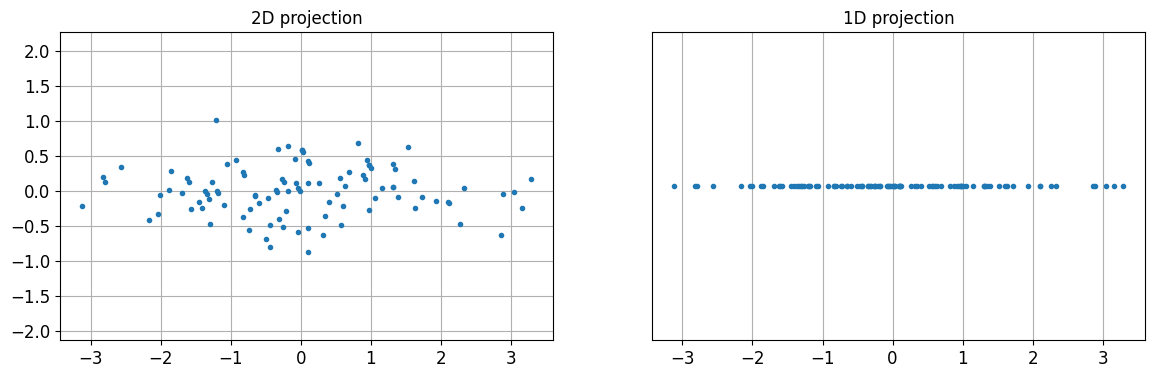

In [86]:
plt.figure(figsize=(14,4))
#plot_axis_combinations(X_pca2_)

plt.subplot(1,2,1)
plt.plot(X_pca2[:,0], X_pca2[:,1], '.')
plt.title('2D projection')
plt.axis('equal')
plt.grid('on')

plt.subplot(1,2,2)
plt.plot(X_pca1, np.zeros(X_pca1.shape), '.')
plt.title('1D projection')
plt.axis('equal')
plt.grid('on')
plt.yticks([])


### 1.1.5 Back-projecting to the original space

Finally, let's try to reconstruct the data from the PCA projects back in the original $M$-dimensional feature space:

* `X_recon1` should be the back projection from 1-D representation `X_pca1`
* `X_recon2` should be the back projection from 1-D representation `X_pca2`

In [87]:
X_recon1 = None # let this store the 3D reconstruction after first projecting to a 1D PCA space
X_recon2 = None # let this store the 3D reconstruction after first projecting to a 2D PCA space

X_recon1 = pca1.inverse_transform(X_pca1)
X_recon2 = pca2.inverse_transform(X_pca2)

In [88]:
assert(X_recon1.shape == X.shape)
assert(X_recon2.shape == X.shape)


We can reuse our earlier plotting functions to show the reconstructed data as a 3D plot,
including the use PCA components.

Note that after back projecting, the data is again 3D, but intrinsically low dimensional as all data points now either lie on a 2D plane or 1D line in the 3D feature space.

In [89]:
print('Reconstruction from 2D PCA')
# make rotatable 3D plot with standard plotting tools
ipywidgets.interactive(
    lambda view_angle1, view_angle2: plot_3d_pca_components(pca2, X_recon2, view_angle1, view_angle2, label_name='feature'),
    view_angle1=(0, 90),
    view_angle2=(0, 360)
)

Reconstruction from 2D PCA


interactive(children=(IntSlider(value=45, description='view_angle1', max=90), IntSlider(value=180, description…

In [90]:
print('Reconstruction from 1D PCA')

# make rotatable 3D plot with standard plotting tools
ipywidgets.interactive(
    lambda view_angle1, view_angle2: plot_3d_pca_components(pca1, X_recon1, view_angle1, view_angle2, label_name='feature'),
    view_angle1=(0, 90),
    view_angle2=(0, 360)
)

Reconstruction from 1D PCA


interactive(children=(IntSlider(value=45, description='view_angle1', max=90), IntSlider(value=180, description…

### 1.1.6 Supervised dimensionality reduction


While PCA is an unsupervised approach, since it doesn't consider the class labels,
it is also possible to create a projection that does consider the class labels,
for instance to maximize the kept variance between the classes, rather than the variance of the overall data.

For intance, we could use LDA to learn such a projection. From Chapter 8:
**Linear Discriminant Analysis (LDA)** *is a classification algorithm, but during training it learns the most discriminative axes between the classes, and these axes can then be used to define a hyperplane
onto which to project the data. The benefit of this approach is that the projection
will keep classes as far apart as possible, so LDA is a good technique to reduce
dimensionality before running another classification algorithm such as an SVM
classifier.*

While the book doesn't go into detail on how the use LDA, the [sklearn interface for LDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis) is very similar to that of PCA for dimensionality reduction.
Similar to PCA, you can set `n_components` in the LDA constructor, and perform fit() and transform() operations. Note that since this is supervised LDA, `n_components` can be at most equal to the number of classes - 1. E.g. in a 2 class problem, we can only find a `n_components=1`-dimensional subspace to best separate these classes.

Use sklearn to create a supervised 1-dimensional LDA projection on the training data $X$, $y$.

In [91]:
X_lda1 = None # X_lda1 will be the result of projecting X with LDA to a 1D space 

# Note that you might need to import the LDA implementation from sklearn first

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)
X_lda1 = lda.fit_transform(X, y)

In [92]:
assert(X_lda1.shape == (100,1))
assert(X_pca1.shape == (100,1))


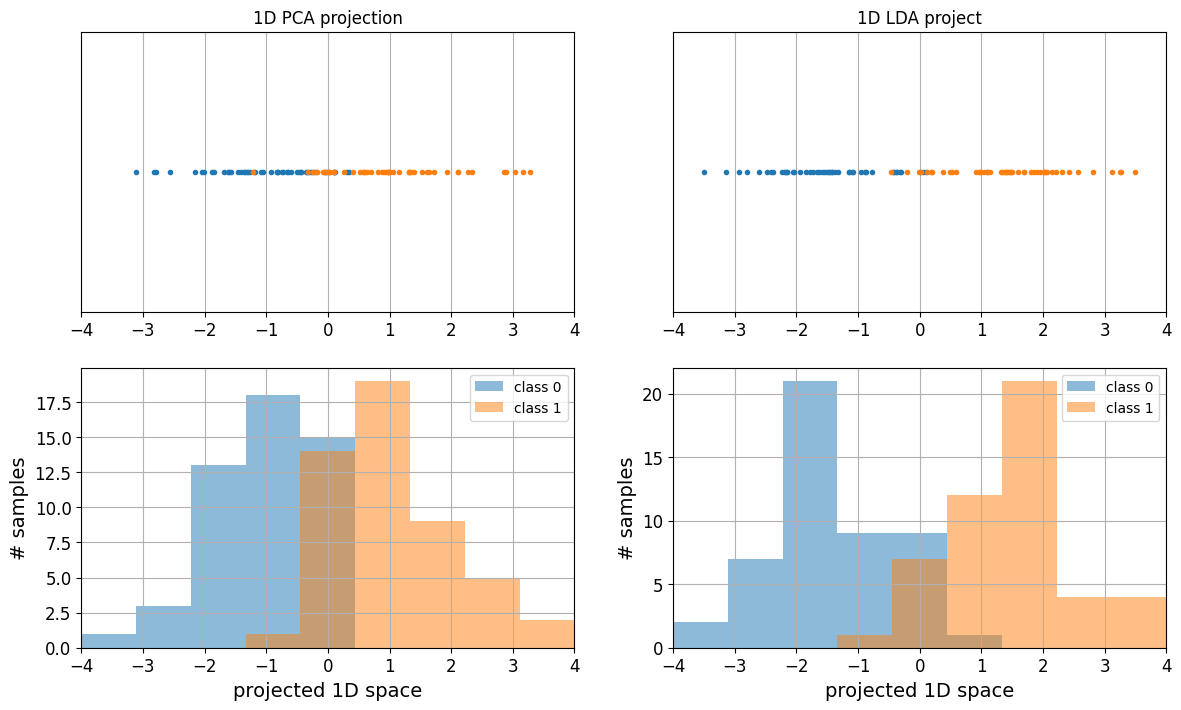

In [93]:
xlims = (-4, 4)

def plot_class_dist_histograms(X_1d, y):
    nbins = 10
    bins = np.linspace(xlims[0], xlims[1], nbins)
    plt.hist(X_1d[y==0], bins, alpha=0.5, label='class 0')
    plt.hist(X_1d[y==1], bins, alpha=0.5, label='class 1')
    #plt.ylim([0., 1.0])
    plt.ylabel('# samples')
    plt.xlabel('projected 1D space')
    plt.legend()

plt.figure(figsize=(14,8))    
plt.subplot(2,2,1)
plt.plot(X_pca1[y==0], np.zeros(X_pca1[y==0].shape), '.')
plt.plot(X_pca1[y==1], np.zeros(X_pca1[y==1].shape), '.')
plt.title('1D PCA projection')
plt.axis('equal')
plt.xlim(xlims)
plt.grid('on')
plt.yticks([])

plt.subplot(2,2,2)
plt.plot(X_lda1[y==0], np.zeros(X_lda1[y==0].shape), '.')
plt.plot(X_lda1[y==1], np.zeros(X_lda1[y==1].shape), '.')
plt.title('1D LDA project')
plt.axis('equal')
plt.xlim(xlims)
plt.grid('on')
plt.yticks([])

plt.subplot(2,2,3)
plot_class_dist_histograms(X_pca1, y)
plt.xlim(xlims)
plt.grid('on')

plt.subplot(2,2,4)
plot_class_dist_histograms(X_lda1, y)
plt.xlim(xlims)
plt.grid('on')


Compare the projected distributions in the plots above for PCA (left column) and LDA (right column). 
Note that the PCA projection doesn't scale the data to preserve the variance, it just defined a new coordinate system in the original space.
The LDA projection on the other hand did scale the data, hence the total variance might appear larger than the PCA variance.

**Q** Which dimensionality reduction method will have a lower Bayes error if you would use the projected data in a 1 dimensional classifier afterwards? Motivate your answer by observations that you make in the plots above.

In [94]:
# ANSWER = None
# ANSWER = "PCA"
# ANSWER = "LDA"
ANSWER = "PCA and LDA have a similar Bayes error"



In [95]:
assert ANSWER in ["PCA","LDA","PCA and LDA have a similar Bayes error"]

## 1.2 Implement your own PCA

The math behind the standard PCA implementaion is pretty straightforward, and explained in chapter 8 of the book.
Let's verify that your implementation performs the same as sklearn's PCA implementation.

Complete the following functions in the code blocks below:

* `pca_fit(X, n_components)` to estimate the PCA transformation to a `n_component`-dimensional subspace
* `pca_transform(m, components, X)` to apply the PCA transformation to data X
* `pca_inverse_transform(mean, components, X_pca)` to perform the back-projection to the original feature space

These functions will behave similar to sklearn's PCA fit(), transform() and inverse_transform() methods.

In [96]:
# NOTE: don't use any sklearn functions in your own (re)-implementation. You can use np.linalg.svd though.

def pca_fit(X, n_components):
    """ Given an N x D input data matrix `X` containing N data samples in a D dimensional space,
        Compute the parameters of the PCA projection, namely
        - mean: the D-dimensional data mean, and
        - components: a `n_components` x D matrix containing the first `n_components` PCA components
        
        Returns: mean, components
    """
    mean = X.mean(axis=0)
    X_centered = X - mean
    components = np.linalg.svd(X_centered)[2]
    components = components[:n_components]

    return mean, components

In [97]:
n_comp = 2

# run your implementation
mean, components = pca_fit(X, n_components=n_comp)

assert( mean.shape == (3,) ) # mean should be 3D vector
assert( components.shape == (n_comp, 3) ) # each of the n components should be a 3D vector

# -- Comparison to Sklearn's PCA implementation --
from sklearn.decomposition import PCA
pca_ref = PCA(n_components=n_comp)
pca_ref.fit(X)

# First, we'll check if you have the same mean vector
assert(np.all( np.isclose(pca_ref.mean_, mean) ))

# Next, we'll check each of the PCA components in turn
# Note that since the sign of a component is arbitray, so we should ensure that signs are aligned
# before comparing the solutions of different PCA implementations

def is_same_within_tolerance(a, b):
    # test if two vectors are similar, within a small numerical error
    return np.all(np.abs(a - b) < 1e-10)

for c in range(n_comp):
    ref_comp = pca_ref.components_[c]
    your_comp = components[c]
    
    print(f'testing if components {c} is  similar ...')
    print('  sklearn PCA:', ref_comp)
    print('     your PCA:', your_comp)
    
    is_similar = is_same_within_tolerance(ref_comp, your_comp)
    is_similar_mirrored = is_same_within_tolerance(ref_comp, -your_comp) # test with flipped sign
    
    if is_similar:
        print('OK: components are the same')
    elif is_similar_mirrored:
        print('OK: components are the same [only sign is flipped]')
    else:
        print('ERROR: components are the different!')
    print()
    assert(is_similar or is_similar_mirrored)

testing if components 0 is  similar ...
  sklearn PCA: [0.46058143 0.0406653  0.88668545]
     your PCA: [-0.46058143 -0.0406653  -0.88668545]
OK: components are the same [only sign is flipped]

testing if components 1 is  similar ...
  sklearn PCA: [-0.88272351 -0.08377057  0.46236533]
     your PCA: [ 0.88272351  0.08377057 -0.46236533]
OK: components are the same [only sign is flipped]



Next, implement the transformation function that projects data X to the learned PCA space. Use standard numpy functions only, don't use any sklearn functions.

In [98]:
def pca_transform(mean, components, X):
    
    X_embedded = (X-mean).dot(components.T)

    return X_embedded


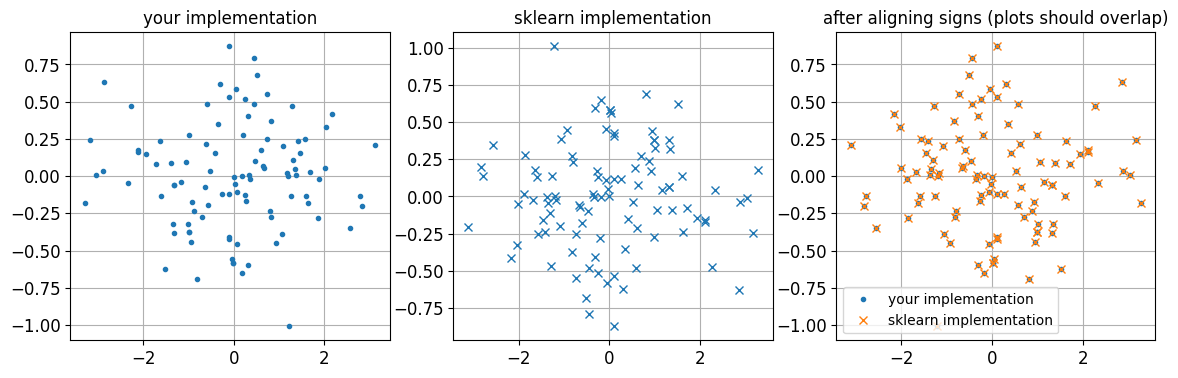

In [99]:
X_pca = pca_ref.transform(X)
X_your_pca = pca_transform(mean, components, X)

assert(X_pca.shape == X_your_pca.shape)

# Let's create a plot of the resulting projections
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.plot(X_your_pca[:,0], X_your_pca[:,1], '.')
plt.title('your implementation')
plt.grid()

plt.subplot(1,3,2)
plt.plot(X_pca[:,0], X_pca[:,1], 'x')
plt.title('sklearn implementation')
plt.grid()

# again, the signs of the projection might be flipped.
#  to ensure that both implementaions use the same sign,
#  we'll flip the sign if the sign of the first element is negative
X_pca_ = X_pca.copy()
X_your_pca_ = X_your_pca.copy()
for c in range(n_comp):
    if X_pca_[0,c] < 0: X_pca_[:,c] = -X_pca_[:,c]
    if X_your_pca_[0,c] < 0: X_your_pca_[:,c] = -X_your_pca_[:,c]


plt.subplot(1,3,3)
plt.plot(X_your_pca_[:,0], X_your_pca_[:,1], '.', label='your implementation')
plt.plot(X_pca_[:,0], X_pca_[:,1], 'x', label='sklearn implementation')
plt.title('after aligning signs (plots should overlap)')
plt.legend()
plt.grid()

# Finally, let's run some asserts to check that the outcomes are indeed the same
assert(np.all(np.abs( X_your_pca_ - X_pca_ ) < 1e-12))

Finally, implement the inverse transformation which projects the points from the embedded PCA space back to the original 3D feature space. Use again standard numpy functions only, don't use any sklearn functions.

In [100]:
def pca_inverse_transform(mean, components, X_pca):
    
    X_reconstruct = X_pca.dot(components)
    X_reconstruct = X_reconstruct + mean

    return X_reconstruct


In [101]:
# your implementation
X_your_reconstruct = pca_inverse_transform(mean, components, X_your_pca)

# sklearn PCA reference
X_ref_reconstruct = pca_ref.inverse_transform(X_pca)

# solutions the same?
assert( X_ref_reconstruct.shape == X_your_reconstruct.shape )
assert( np.all( np.abs( X_ref_reconstruct - X_your_reconstruct ) < 1e-12 ) )

# visually verify that your code has projected all points to a 2D plane in the original 3D feature space

# Note: using X_your_reconstruct here
ipywidgets.interactive(
    lambda view_angle1, view_angle2: plot_3d_data(X_your_reconstruct, view_angle1, view_angle2, label_name='feat.'),
    view_angle1=(0, 90),
    view_angle2=(0, 360)
)

interactive(children=(IntSlider(value=45, description='view_angle1', max=90), IntSlider(value=180, description…

For any given dataset, the number of possible PCA components is bounded by the number of samples and number of features.
Express this straightforward relationship by completing the following function.

If you don't know the answer, realize that the PCA components are defined by the number of non-zero eigenvalues of the data covariance matrix, e.g. the rank of the covariance matrix. Of course, you could also just experiment with sklearn's implementation and see what works, or look it up somewhere ;)

In [102]:
def max_possible_PCA_components_for_given_dataset(num_samples, num_features):
    
    max_components = min(num_samples, num_features)
    return max_components


In [103]:
# Test same sample cases
num_samples = 3
num_features = 3
n_comp = max_possible_PCA_components_for_given_dataset(num_samples, num_features)
print(f'Maximimum number of PCA components for dataset with {num_samples} samples and {num_features} features: {n_comp}')

num_samples = 1000
num_features = 42
n_comp = max_possible_PCA_components_for_given_dataset(num_samples, num_features)
print(f'Maximimum number of PCA components for dataset with {num_samples} samples and {num_features} features: {n_comp}')

num_samples = 300
num_features = 1024
n_comp = max_possible_PCA_components_for_given_dataset(num_samples, num_features)
print(f'Maximimum number of PCA components for dataset with {num_samples} samples and {num_features} features: {n_comp}')


Maximimum number of PCA components for dataset with 3 samples and 3 features: 3
Maximimum number of PCA components for dataset with 1000 samples and 42 features: 42
Maximimum number of PCA components for dataset with 300 samples and 1024 features: 300


## 1.3 Eigen-pedestrians

Now that we have explored PCA with some toy data, let's apply it to some real world data.
You are given a dataset containing 1500 gray-scale pedestrian image patches obtained from a driving vehicle.
The $25 \times 50$ pixel images have been reshaped to 1250-dimensional feature vectors.

We start by loading the dataset from disk:

In [104]:
import scipy.io
data_int = scipy.io.loadmat('data/ped_int.mat')

X_ped = data_int['ped_int']

We first explore the dataset a bit. As we have done in earlier assignments,
it is possible to visualize the feature vectors back as  gray-level intensity images by resizing
them to their original size. 

Number of training samples: 1500
        Number of features: 1250


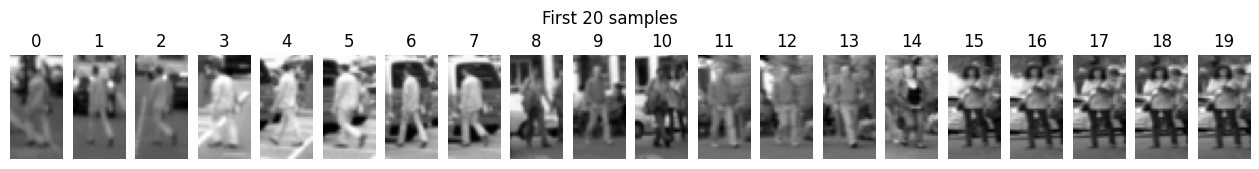

In [105]:
IM_HEIGHT = 50
IM_WIDTH = 25

# check we have correcly loaded the data
assert(X_ped.shape[1] == IM_HEIGHT * IM_WIDTH)

def feat_to_image(X):
    return X.reshape(IM_WIDTH, IM_HEIGHT).T

def plot_feat_as_image(X):
    image = feat_to_image(X)
    plt.imshow(image, cmap=mpl.cm.gray)
    plt.axis("off")

def plot_multiple_feats_as_images(X, num_cols=10, suptitle=None):
    plt.figure(figsize=(16,2))
    
    for i in range(num_cols):
        sample = X[i]
        image = feat_to_image(sample)

        plt.subplot(1,num_cols,i+1)
        plt.imshow(image, cmap=mpl.cm.gray)
        plt.title('%d' % i)
        plt.axis('off')
    
    if suptitle:
        plt.suptitle(suptitle)
        
print('Number of training samples:', X_ped.shape[0])
print('        Number of features:', X_ped.shape[1])

plot_multiple_feats_as_images(X_ped, 20, suptitle='First 20 samples')

### 1.3.1 PCA on image data

In all these images there is a pedestrian in the center, with some variations in pose, viewpoint, clothing, lighting conditions, background, body size, etc.
We can use PCA to capture the main modes of variation in these images,
similar to what we have done in 3D toy example, but now using 1250 features.


**Q**: How many PCA components could we maximimally compute for this pedestrian dataset?

In [106]:
MAX_PCA_COMPONENTS_FOR_PED_DATASET = 1250

In [107]:
print('Maximimum number of PCA components for a pedestrian dataset:')
print(MAX_PCA_COMPONENTS_FOR_PED_DATASET)

assert(isinstance(MAX_PCA_COMPONENTS_FOR_PED_DATASET, int))


Maximimum number of PCA components for a pedestrian dataset:
1250


Ok, let's fit a 50-dimensional PCA transformation for this dataset:

In [108]:
pca = None # store sklearn's PCA object here
X_ped_pca = None # store the PCA projection of X_ped here

pca = PCA(n_components=50)
X_ped_pca = pca.fit_transform(X_ped)

In [109]:
assert(not pca is None)
assert(X_ped_pca.shape == (1500,50))
sklearn.utils.validation.check_is_fitted(pca) # will throw error if not fitted



Since the features in X represent the intensity values of the individual pixels in the images,
the 1250-dimensional mean feature vector contains the mean intensity value of each pixel over the whole dataset,
and can thus also be visualized as an image.

Text(0.5, 1.0, 'Mean feature')

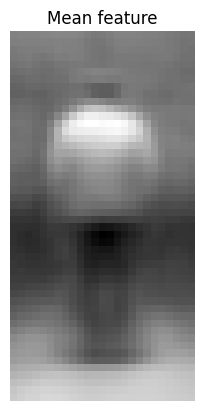

In [110]:
plot_feat_as_image(pca.mean_)
plt.title('Mean feature')

Likewise, the PCA components which represent the main axes of variation in the 1250-dimensional dataset can *also* be visualized as images.

We'll refer to these images as the **"Eigen-pedestrians"**, similar to the concept of [Eigenfaces](https://en.wikipedia.org/wiki/Eigenface),
as we can reconstruct pedestrian images from our target distribution very accuratly using only the mean image and a small number of these eigen-pedestrians.

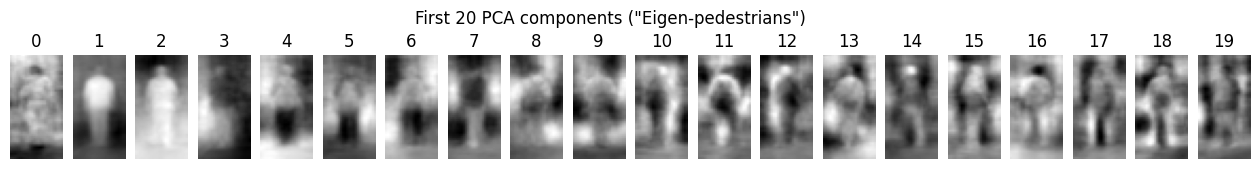

In [111]:
plot_multiple_feats_as_images(pca.components_, 20, suptitle='First 20 PCA components ("Eigen-pedestrians")')

Note how we can recreate different pedestrian images by taking a linear combinations of these PCA components,
and adding them to the mean

In [112]:
def plot_show_pca_reconstruction(w0=0, w1=0., w2=0., w3=0., w4=0., w10=0., w18=0.):
    # the indices of the PCA components in this function's arguments
    idxs = np.array([0, 1, 2, 3, 4, 10, 18])
    
    # construct weight vector with given values
    w = np.array([w0, w1, w2, w3, w4, w10, w18])
    
    x = pca.mean_ + w.dot(pca.components_[idxs])
    
    image = feat_to_image(x)
    plt.imshow(image, cmap=mpl.cm.gray) # note. mpl.cm.binary inversts the colors
    plt.axis("off")

wrange = (-1600., 1600.)
ipywidgets.interact(plot_show_pca_reconstruction, w0=wrange, w1=wrange, w2=wrange, w3=wrange, w4=wrange, w10=wrange, w18=wrange)

interactive(children=(FloatSlider(value=0.0, description='w0', max=1600.0, min=-1600.0), FloatSlider(value=0.0…

<function __main__.plot_show_pca_reconstruction(w0=0, w1=0.0, w2=0.0, w3=0.0, w4=0.0, w10=0.0, w18=0.0)>

## 1.4 Compression

We will now try to see how we can compress the pedestrian images by using only a few Eigen-pedestrians.
Complete the function below which takes the dataset, and a given number of Eigen-pedestrians (PCA components),
and use it to 

1. first compress the data to `n_components` with PCA, and then.
2. reconstruct the images from the compressed representation.


In [113]:
def compress_and_decompress_with_pca(X_ped, n_components):
    """ Compress and decompress features in dataset X_ped
        by first projecting the data to a PCA subspace with n_components,
        and the reconstructing the data from this PCA embedding.
        
        Input: X_ped - N x M dataset
        Input: n_components - integer, target number of components for compression
        Returns: X_reconstruct - N x M with reconstructed data after compression
    """
    pca = PCA(n_components=n_components)
    X_ped_pca = pca.fit_transform(X_ped)
    X_reconstruct = pca.inverse_transform(X_ped_pca)

    return X_reconstruct

In [114]:
X_reconstruct = compress_and_decompress_with_pca(X_ped, n_components=20)

# reconstruction should keep the dimensionality of the input
assert(X_reconstruct.shape == X_ped.shape)

# after compression with 0 components, all samples should just be equal to the mena
#  so we should see no variance left in the data
X_reconstruct = compress_and_decompress_with_pca(X_ped, n_components=0)
assert(np.all( X_reconstruct.var(axis=0) < 1e-10))

Now we can below interactivaly visualize the result and see what happens if we increase step by step the number of components from 0 to 1, 2, 3, etc.

In [115]:
def plot_pca_compression(n_components):
    X_reconstruct = compress_and_decompress_with_pca(X_ped, n_components)

    print(f'num components: {n_components}') 
    plot_multiple_feats_as_images(X_ped, suptitle='original data')
    plot_multiple_feats_as_images(X_reconstruct, suptitle=f'reconstruction with {n_components} PCA components (+ mean)')

ipywidgets.interact(plot_pca_compression, n_components=ipywidgets.IntSlider(0, min=0,max=1250, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='n_components', max=1250), Outpu…

<function __main__.plot_pca_compression(n_components)>

You should see that especially in the beginning with few components, adding an additional component has a large impact on the reconstruction quality, since these initial components still explain a lot of the variance in the data.

**Q** If we want to lossy compress a dataset $X$ with $N$ samples and a $M$-dimensional feature space, with only $D$ PCA components, how much storage space have we gained?

To compute the compression rate $r$, 
we have to consider
- how many numbers were needed to represent the original data set (i.e. the number of elements in the matrix X), and
- how many numbers are needed to represent the compressed data
- how many numbers are needed to store the "compression information", i.e. the relevant PCA parameters.

In fact, you can use the following formula:
$r = \frac{N(X)}{N(X_{pca}) + D*N(comp) + N(mean)}$

where:
- $N(X)$ is the number of (floating point) numbers in the original data set $X$
- $N(X_{pca})$ is the number of numbers in the PCA compressed data set $X_{pca}$
- $N(comp)$ is the number of (floating point) numbers to represent a single PCA component
- $N(mean)$ is the number of (floating point) numbers to represent the mean feature

In [116]:
def compute_data_compression_rate(N, M, D):
    # YOUR CODE HERE
    raise NotImplementedError()
    return COMPRESSION_RATIO

In [117]:
N = 1500
M = 1024
D = 50

COMPRESSION_RATIO = compute_data_compression_rate(N, M, D)
print(f'With {D} PCA components, {N} samples in a {M}-dimensional feature space')
print('can be compressed  by a factor %.2fx' % COMPRESSION_RATIO)

NotImplementedError: 

## 1.5 Explained Variance

Let's inspect how the number of PCA components affects the amount of variance in that data that the project keeps.


First, let's formalize how we compute the total variance in the data. 
For some data matrix $X$ of N observations with M features. Let $\text{Var}_j(X)$ be the variance of feature $j$ over $N$ samples $\{x_{1j}, ..., x_{Nj} \}$. Then the total variance in $X$ is calculated by summing the M variances: 

$$ \text{total\_variance}(X) = \sum_{1 \leq j \leq M} \text{Var}_j(X)$$


Implement the function which computes the total variance in a given $N \times M$ data matrix $X$.

In [118]:
def total_variance_in_data(X):
    
    total_variance = np.sum(np.var(X, axis=0))
    
    return total_variance

In [119]:
X_toy = np.array([[0,1], [10,2], [20,3]])
# total variance on X_toy is (variance([0,10,20]) + variance([1,2,3]))
assert(np.abs( total_variance_in_data(X_toy) - (np.var([0,10,20])+np.var([1,2,3])) ) < 1e-6)

total_variance_in_X_ped = total_variance_in_data(X_ped)


With this definition, we can easily compute the amount of variance from the original data `X` that is maintained in in `X_pca`, the data after the project.

In [120]:
def total_variance_ratio_in_data(X, X_pca):
    """ Compute the ratio of variance in the original data X
        still present in compressed data X_pca:
        
           total-ratio = amount-variance-in-X_pca / amount-variance-in-X
        
        Note that the amount of variance of a dataset X is 
        defined as the sum of the variance of each feature in that data.
    """
    var_in_X = total_variance_in_data(X)
    var_in_X_pca = total_variance_in_data(X_pca)
    total_variance_ratio = var_in_X_pca / var_in_X
    
    return total_variance_ratio

Calculate the total variance explained by the PCA components relative to the total variance in the data.

In [121]:
variance_explained_ratio = total_variance_ratio_in_data(X_ped, X_ped_pca)
print('Ratio of kept variance by comparing X_ped and X_ped_pca: %.2f' % (variance_explained_ratio*100.))

# these numbers should be identical
assert 0.<= variance_explained_ratio and variance_explained_ratio <= 1.0


Ratio of kept variance by comparing X_ped and X_ped_pca: 86.10


**Q**: What is the minimum number of PCA components if we want to keep at least 80% of the variance?

In [122]:
NUMBER_OF_COMPONENTS_NEEDED = -1

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum>=0.8)
NUMBER_OF_COMPONENTS_NEEDED = d

In [123]:
print('Your answer: at least', NUMBER_OF_COMPONENTS_NEEDED, 'are needed to explain 80% of the variance in the data')


Your answer: at least 30 are needed to explain 80% of the variance in the data


# 2. Clustering

We start again by exploring some clustering techinques on a toy dataset,
which is generated here:

In [124]:
from sklearn.datasets import make_blobs

# Create toy dataset
n_samples = 1000

X, y = make_blobs(n_samples=n_samples,
    cluster_std=[0.5, 2.0, 1.5],
    random_state=15)

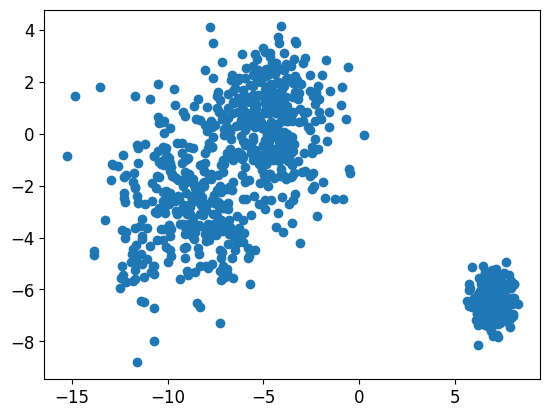

In [125]:
# Show plot of the data
def plot_data_with_labels(X, y=None):
    s = plt.scatter(X[:,0], X[:,1], c=y)
    if not y is None:
        plt.legend(*s.legend_elements())
        
plot_data_with_labels(X)

One common algorithm used to cluster data is **k-means**.
In the block below,

* use sklearn's k-Means implementation to cluster the given data `X`, and predict each sample's cluster label. Initialize k-Means by assuming that there are $k=3$ clusters in the data.
* also obtain the predictions of the fitted k-Means solutions on all samples in `X`, and call this `y_pred_km`.

In [126]:
k = 3

kmeans = None # store sklearns k-Means implementation here
y_pred_km = None # store the predicted cluster labels for data X here 

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_pred_km = kmeans.predict(X)


/home/nathan/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [127]:
assert( kmeans != None )
assert( len(np.unique(y_pred_km)) == 3 )
assert( y_pred_km.shape == (n_samples,) )


Let's checkout the cluster labels that the algorithm found:

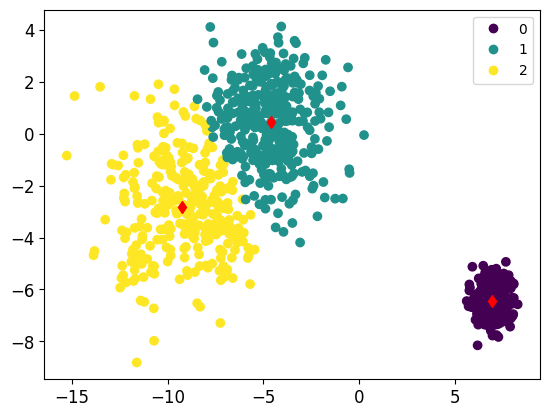

In [128]:
# color the samples with the predicted labels
plot_data_with_labels(X, y_pred_km)

# also show the cluster centers found by k-Means
plt.plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 'rd')

Alternatively, we could fit a Gaussian Mixture distribution on the data,
and label the samples based on their probability under the fitted mixture components.

In the code below, fit a Gaussian Mixture on the data using $k=3$ mixture components.

In [129]:
gm = None # store your sklearn GaussianMixture here
y_pred_gm = None # store the predicted class labels from the GaussianMixture here

from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3)
gm.fit(X)
y_pred_gm = gm.predict(X)

In [130]:
assert( gm != None )
assert( len(np.unique(y_pred_gm)) == 3 )
assert( y_pred_gm.shape == (n_samples,) )


Let's again visualize the result, and compare it to k-Means.
You should see that the plots look pretty similar, except perhaps for a few samples near the cluster boundaries.

Text(0.5, 1.0, 'Gaussian Mixture')

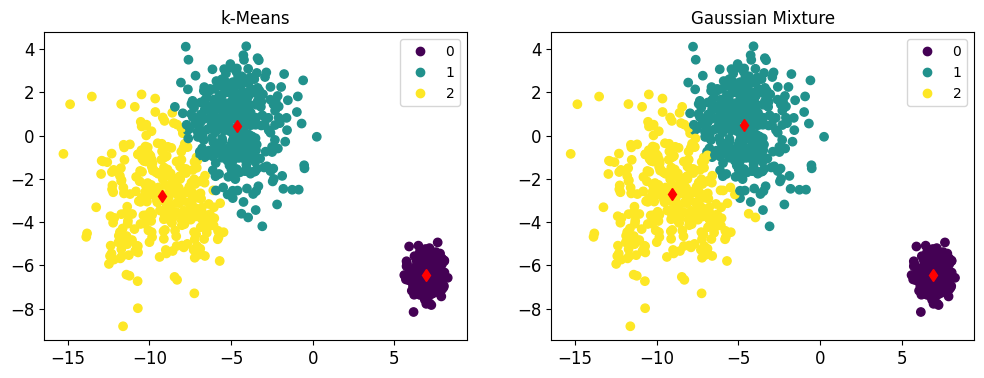

In [131]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 'rd')
plot_data_with_labels(X, y_pred_km)
plt.title('k-Means')

plt.subplot(1,2,2)
plt.plot(gm.means_[:,0], gm.means_[:,1], 'rd')
plot_data_with_labels(X, y_pred_gm)
plt.title('Gaussian Mixture')

## 2.1 Implement k-means algorithm

The basic k-Means algorithm actually consists only a few steps:

1. initialize k cluster centers by picking k random samples
2. assign samples to nearest cluster center
3. for each cluster k, compute the new center as the mean of the assigned samples
4. go to step 2, until convergence or sufficient iterations have passed

In the code blocks below, you will implement steps 1 to 3.

Implement **step 1**: select k samples as random samples from X and set these as cluster centers.
*HINT:* you can use `np.random.choice` to randomly select k indices from a given range.

In [132]:
def initialize_centers(k, X):
    """ randomly select k rows from data matrix X
        and return these as the k cluster centers.
        
        input: k - an integer
        input: X - a N x D matrix
        output: center - a k x D matrix containing k initial cluster centers
    """ 
    random_indices = np.random.choice(len(X), size=k, replace=False)
    centers = X[random_indices]
    return centers

Text(0.5, 1.0, 'Initial cluster centers (no data assigned yet)')

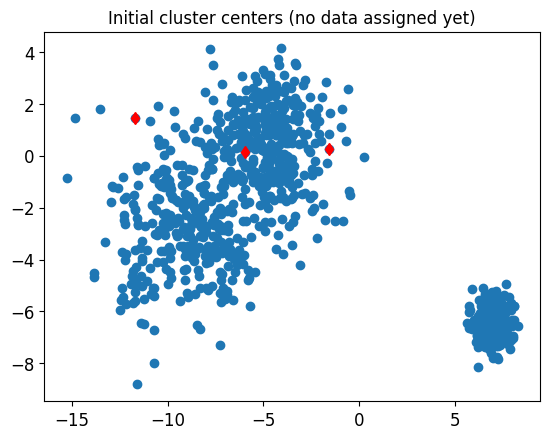

In [133]:
k = 3

np.random.seed(5)
centers = initialize_centers(k, X)

assert(centers.shape == (k, 2)) # k centers in a 2D feature space

centers_init = centers.copy() # keep a copy to compare later to

# let's plot the randomly selected cluster centers
plot_data_with_labels(X)
plt.plot(centers[:,0], centers[:,1], 'rd')
plt.title('Initial cluster centers (no data assigned yet)')

Implement **step 2**: assign all data points to nearest centers (in terms of Euclidean distance)
*Hint:* you can use `scipy.spatial.distance.cdist` to quickly compute the distance of the samples to the cluster centers.


In [134]:
import scipy

def assign_samples_to_centers(centers, X):
    
    distance0 = scipy.spatial.distance.cdist(X, centers[0].reshape(1, 2), metric='Euclidean')
    distance1 = scipy.spatial.distance.cdist(X, centers[1].reshape(1, 2), metric='Euclidean')
    distance2 = scipy.spatial.distance.cdist(X, centers[2].reshape(1, 2), metric='Euclidean')


    cluster_idxs = np.zeros(len(X), dtype=int)

    cluster_idxs[np.logical_and(distance0<distance1, distance0<distance2).flatten()] = 0
    cluster_idxs[np.logical_and(distance1<distance0, distance1<distance2).flatten()] = 1
    cluster_idxs[np.logical_and(distance2<distance0, distance2<distance1).flatten()] = 2

    return cluster_idxs

Text(0.5, 1.0, 'Assigning data to nearest cluster centers')

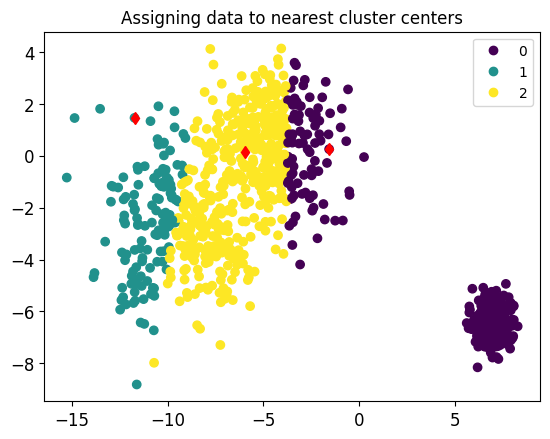

In [135]:
cluster_idxs = assign_samples_to_centers(centers, X)

assert( cluster_idxs.shape == (n_samples,) )
assert(cluster_idxs.min() >= 0) # lowest possible cluster id is 0
assert(cluster_idxs.max() < k) # highest possible cluster id is k-1

# Let's see how the samples were assigned to the randomly picked cluster centers
plt.plot(centers[:,0], centers[:,1], 'rd')
plot_data_with_labels(X, cluster_idxs)
plt.title('Assigning data to nearest cluster centers')

Implement **step 3**: compute new center means based on the assigned cluster labels.
In this step, iterate over the k cluster labels, and compute the center of cluster $c$ as the mean of all samples in X assigned to $c$ in `cluster_idxs`.
The result is a new set of $k$ cluster centers, based on the current assignment.

In [136]:
def update_center_means(k, X, cluster_idxs):
    
    mean0 = np.mean(X[cluster_idxs==0], axis=0)
    mean1 = np.mean(X[cluster_idxs==1], axis=0)
    mean2 = np.mean(X[cluster_idxs==2], axis=0)
    
    centers = np.array((mean0, mean1, mean2))

    return centers

Text(0.5, 1.0, 'After recomputing the cluster centers')

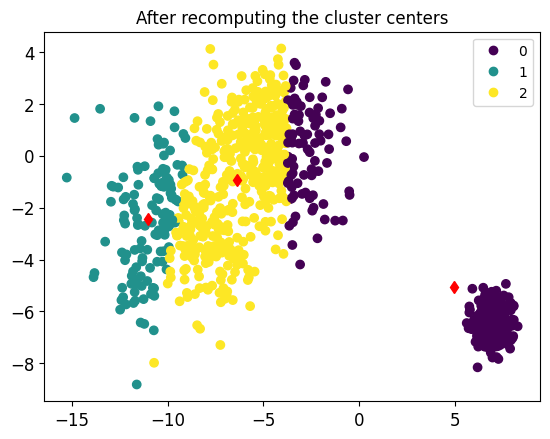

In [137]:
centers = update_center_means(k, X, cluster_idxs)

assert(centers.shape == (k, 2)) # k centers in a 2D feature space

# check that the centers have changed w.r.t. the initial centers that we stored in center_init above
assert(np.all( centers_init != centers ))

# Show the new assignment
plt.plot(centers[:,0], centers[:,1], 'rd')
plot_data_with_labels(X, cluster_idxs)
plt.title('After recomputing the cluster centers')

That's it! If you have implemented these steps correctly, we can run all step sequentially for a few iterations.
Notice how after a few iterations already the cluster centers are not moving much anymore.
Once we detect that the number of samples assigned to each cluster haven't changed, we can quit iterating.

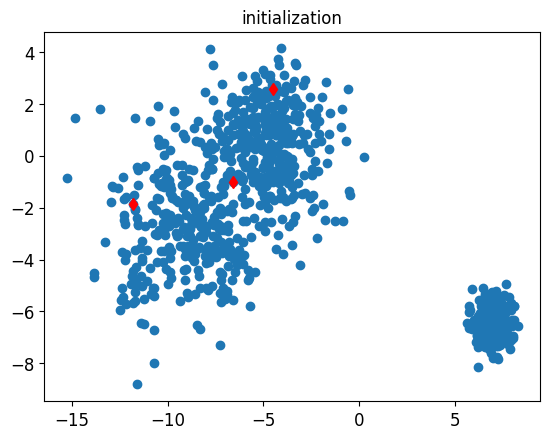

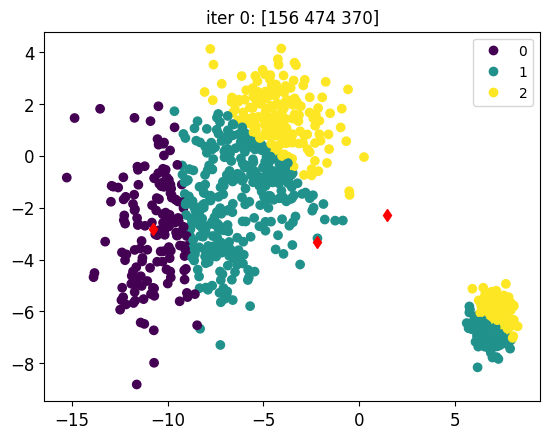

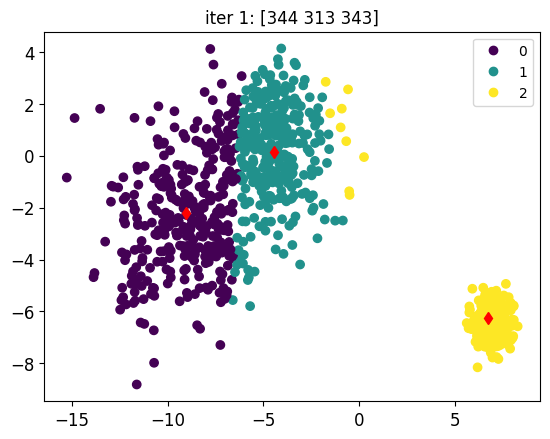

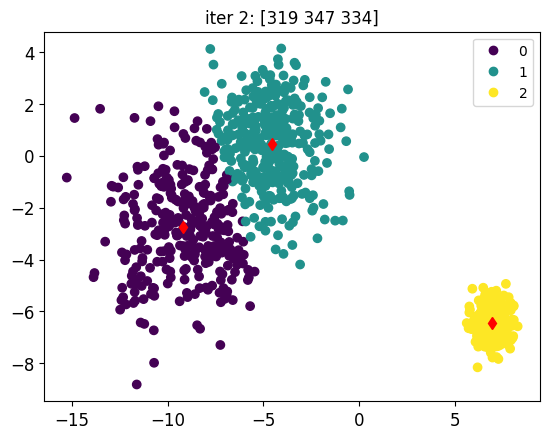

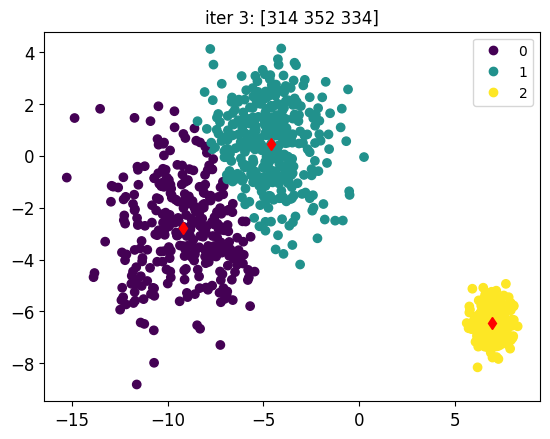

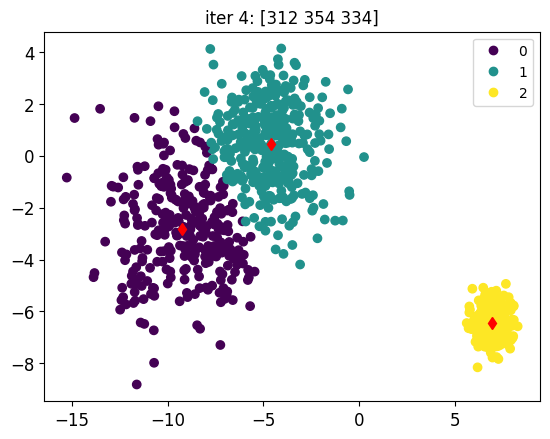

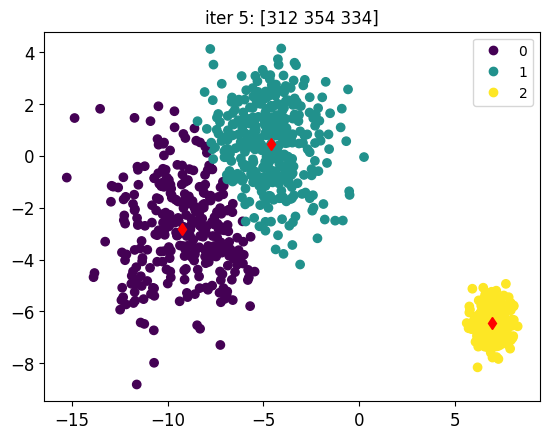

Converged in 5 iterations!


In [138]:
k = 3

# Step 1
centers = initialize_centers(k, X)

plt.plot(centers[:,0], centers[:,1], 'rd')
plot_data_with_labels(X)
plt.title('initialization')
plt.show()

max_iters = 10
last_cluster_counts = np.zeros(k)
for j in range(max_iters):
    # Step 2
    cluster_idxs = assign_samples_to_centers(centers, X)
    
    # Step 3
    centers = update_center_means(k, X, cluster_idxs)

    # Show intermediate result
    cluster_counts = np.bincount(cluster_idxs, minlength=k)
    plt.title(f'iter {j}: ' + str(cluster_counts))
    plt.plot(centers[:,0], centers[:,1], 'rd')
    plot_data_with_labels(X, cluster_idxs)
    plt.show()
    
    # Step 4: continue with next iteration, unless converged
    if np.all(cluster_counts == last_cluster_counts):
        # detected cluster assignment didn't change anymore since last iteration,
        # so cluster centers have converged now
        print(f'Converged in {j} iterations!')
        break # quit the for-loop
    else:
        # keep this iteration's cluster counters to compare to in next iteration
        last_cluster_counts = cluster_counts

### 2.1.1 Finding the outliers

Let's try to do some anomaly detection, that is finding outliers which are dissimilar to most of the rest of the taining data. One approach one might come up with is to consider any sample "sufficiently" far away from a cluster center as an outlier. With k-Means we can reuse the scoring metric used to assign samples to cluster centers, thus a sample is considered an outlier if its Euclidean distance to nearest cluster center is above a certain distance threshold.

Complete the function `find_kmeans_distance_outliers()` below to implement this outlier detection method.

In [139]:
def find_kmeans_distance_outliers(kmeans, X, dist_thresh):
    """
    Determine for each sample in X if it is an outlier or not.
    Outliers are found by finding the distance to the closest cluster center.
    If this smallest distance is above the given threshold `dist_thresh`,
    then the sample is an outlier
    
    Input: kmeans - a fitted instance of sklearn's KMeans class
    Input: X - a N x M dataset of N samples with M features
    Input: dist_thresh - a number, outliers are more distance than this to all cluster centers
    Returns: is_outlier - a N-dimensional Boolean numpy vector,
             is_outlier[i] is True only if sample X[i] is an outlier.
    """
    
    clusters = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    centers_arr = np.zeros((len(X), 2))

    centers_arr[clusters==0] = centers[0]
    centers_arr[clusters==1] = centers[1]
    centers_arr[clusters==2] = centers[2]
    
    is_outlier = np.greater(np.linalg.norm(X - centers_arr, axis=1), dist_thresh)

    return is_outlier

In [140]:
is_outlier = find_kmeans_distance_outliers(kmeans, X, dist_thresh=2.0)
assert(len(is_outlier) == n_samples)
assert(is_outlier.dtype == bool)


In [141]:
# Create interactive widget to explore outliers
def show_kmeans_outliers(dist_thresh):
    is_outlier = find_kmeans_distance_outliers(kmeans, X, dist_thresh)
    
    plt.plot(X[~is_outlier,0], X[~is_outlier,1], '.', label='inlier')
    plt.plot(X[is_outlier,0], X[is_outlier,1], '.', label='outlier')
    plt.plot(centers[:,0], centers[:,1], 'rd')
    plt.legend()
    plt.grid('on')

ipywidgets.interact(show_kmeans_outliers, dist_thresh=(0., 5.0))

interactive(children=(FloatSlider(value=2.5, description='dist_thresh', max=5.0), Output()), _dom_classes=('wi…

<function __main__.show_kmeans_outliers(dist_thresh)>

However, a better way could be to use a density estimation technique, such as a Gaussian Mixture Model, as seen in the book. To use the Gaussian Mixture for outlier detection, we could now score the samples with respect to the distribution fit on all the data,  i.e. we compute the log probability density of each sample under the distribution.
An outlier is than a sample for which the log probability is under a given threshold

As you did for k-Means outlier detection, complete the function below:

In [172]:
def find_gm_logprob_outliers(gm, X, logprob_thresh):
    """
    Determine for each sample in X if it is an outlier or not.
    Outliers are found by finding the log-probability under the fitted Gaussian mixture.
    If this log probability is BELOW the given threshold `logprob_thresh`,
    then the sample is an outlier.
    
    Input: gm - a fitted instance of sklearn's GaussianMixture class
    Input: X - a N x M dataset of N samples with M features
    Input: logprob_thresh - a number, outliers how a log-probability under the GM below this threshold
    Returns: is_outlier - a N-dimensional Boolean numpy vector,
             is_outlier[i] is True only if sample X[i] is an outlier.
    """

    densities = gm.score_samples(X)
    is_outlier = densities < logprob_thresh
    return is_outlier

In [173]:
is_outlier = find_gm_logprob_outliers(gm, X, logprob_thresh=-7.0)
assert(len(is_outlier) == n_samples)
assert(is_outlier.dtype == bool)


Let's take a look at the distribution of log probabilities for our dataset, and see if we can get an idea in what range we should put our cutoff threshold:

Text(0, 0.5, 'number of samples')

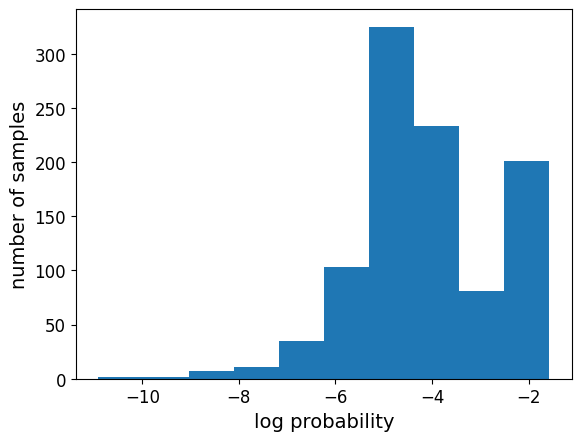

In [174]:
plt.hist(gm.score_samples(X));
plt.xlabel('log probability')
plt.ylabel('number of samples')

We can see that most samples have a log probability above approximately -7.
A cutoff threshold in the range -8 and -6 is probably good, we could reasonably argue that the samples in the tail of this distribution are outliers. Of course in practice the cutoff would be depend on your task, so this is not a general rule.

We can study the effect of different thresholds in the code block below.

In [175]:
# Create interactive widget to explore outliers
def show_gm_outliers(logprob_thresh):
    is_outlier = find_gm_logprob_outliers(gm, X, logprob_thresh)
    
    plt.plot(X[~is_outlier,0], X[~is_outlier,1], '.', label='inlier')
    plt.plot(X[is_outlier,0], X[is_outlier,1], '.', label='outlier')
    plt.plot(gm.means_[:,0], gm.means_[:,1], 'rd')
    plt.legend()
    plt.grid('on')

ipywidgets.interact(show_gm_outliers, logprob_thresh=(-12., .0))

interactive(children=(FloatSlider(value=-6.0, description='logprob_thresh', max=0.0, min=-12.0), Output()), _d…

<function __main__.show_gm_outliers(logprob_thresh)>

Compare the earlier outlier detection method using the Euclidean distance to the cluster center to this approach of using the log probability under the GMM.

**Q**: What happens when you try to detect possible outliers in the smaller cluster in the bottom-right? Explain what you observe with the Euclidean-distance based detection method, and what you observe with the Gaussian Mixture detection method. What causes these differences?

*Hint*: think about how the distance between the a sample and the center (mean) are used in the formula for the Gaussian distribution.

The Gaussian takes into consideration the variances of each cluster. The Euclidean only considers the distance from the cluster center. 

Different sized clusters therefore pose a problem in the Euclidean method. As can be observed in our problem aswell.
At a certain threshold the smaller cluster correctly identifies its outliers, while the bigger cluster wrongfully identifies samples as outliers.
At the point where the bigger clusters correctly identify their outliers, the smaller cluster doesn't condsider any sample to be an anomaly anymore.

The Gaussian considers the same distance, but proportionalizes it to the variance of the cluster. Making it possible to find a single threshold for which different sized clusters can correctly identify anomalies.

We end this part with a note.

An even better way to find outliers with respect to the overall data, would be to fit the distribution on all data EXCEPT the sample we are scoring, since we are now 'testing' the distribution on a sample in the 'training' data.
This is what the book refers to *novelty detection*, but an outlier could be consider a novelty w.r.t. the rest of the training data.

However, since in these examples we are using few mixture components the overall distributions should not change too much of we keep the test sample included (bias-variance trade-off) and it is much faster to fit the distribution once and test all N samples, instead of fitting a distribution N times for all test samples separately.

## 2.2 Clustering faces

For the final part, let's consider a social robot that moves around a building,
and continously bumps into people. Using a trained object detector,
it can detect and locate faces in its camera image.
Using the bounding box, a square patch around a detected face could be extracted.
Over time, the robot would build a dataset of faces, some belonging to the same people and others not.
Can you help the robot determine which faces probably correspond to the same person?

![Pepper, the social robot (image source: Wikipedia)](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a1/SoftBank_pepper.JPG/330px-SoftBank_pepper.JPG)


For this exercise we will use the `Olivetti faces dataset`, containing 400 data samples, with 10 samples for 40 persons.
Each sample is a $64 \times 64$ gray scale image patch, reshaped into a 4096-dimensional feature vector.
The class labels of this dataset represent the person identitiy, so all samples with the same class label are taken from the same person.
We will pretend that these are the (gray scale) face image patches that our robot has collected.
The dataset actually contains a set of face images taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. 


Note that the first time you run the code below, sklearn will automatically downloads the data
archive from AT&T. The result will be cached, so once it is on your computer it will not need to download it again.

In [176]:
# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

ALLOW_DOWNLOAD = True

#data = sklearn.datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4, download_if_missing=ALLOW_DOWNLOAD)
data = sklearn.datasets.fetch_olivetti_faces(download_if_missing=ALLOW_DOWNLOAD)

# To see more information on the downloaded dataset, execute the following line:
#print(data['DESCR'])

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/nathan/scikit_learn_data


In [177]:
X, y = data['data'], data['target']

print('Dataset size:', X.shape)
print('Unique person ids:', np.unique(y))

Dataset size: (400, 4096)
Unique person ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


To get an idea of the contents of this dataset, we can explore the features in this dataset by resizing them to $64 \times 64$ images.

In [178]:
def show_face(idx):
    x = X[idx]
    x = x.reshape((64,64))
    label = y[idx]
    plt.imshow(x, cmap='gray')
    plt.title(f'sample={idx}, label={label}')
    plt.axis('off')

ipywidgets.interact(show_face, idx=(0,399))

interactive(children=(IntSlider(value=199, description='idx', max=399), Output()), _dom_classes=('widget-inter…

<function __main__.show_face(idx)>

In the code block below, compare 3 methods of dimensionality reduction to visualize the data in the 4096-dimensional space in a 2D plot, namely:

1. Principal Component Analysis (see Part 1 of the exercises)
2. Linear Discriminant Analysis (see Part 1 of the exercises)
3. t-distributed Stochastic Neighbor Embedding (t-SNE)

Check the sklearn documentation on [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html?highlight=tsne#sklearn.manifold.TSNE) if you are not sure how to use it.

In [ ]:
%%time

# set these variables
X_pca = None # result of dim. reduction with PCA
X_lda = None # result of dim. reduction with LDA
X_tsne = None # result of dim. reduction with t-SNE

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert(X_pca.shape == (400, 2))
assert(X_lda.shape == (400, 2))
assert(X_tsne.shape == (400, 2))


Afterwards, we can visualize the data in the projected space.
We will also in color the points in all plots using the true class labels, such that we can see if the resulting embedding has placed points from the same class together or not.

In [ ]:
def plot_2D_embedded_classes(X, y):
    for c in np.unique(y):
        plt.plot(X[y==c,0], X[y==c,1], '.', label='%d'%c)
    plt.grid()
    plt.axis('equal')

plt.figure(figsize=(14, 4))
plt.subplot(1,3,1)
plot_2D_embedded_classes(X_pca, y)
plt.title('PCA')

plt.subplot(1,3,2)
plot_2D_embedded_classes(X_lda, y)
plt.title('LDA')

plt.subplot(1,3,3)
plot_2D_embedded_classes(X_tsne, y)
plt.title('TSNE')

**Q1:** Which of these 3 dimensionality reduction techniques appear deterministic, and which stochastic (i.e. provide different results every time you run it?)

In [ ]:
# To answer, set each variable to either True or False

#Q1
PCA_IS_DETERMINISTIC = None
LDA_IS_DETERMINISTIC = None
TSNE_IS_DETERMINISTIC = None

# YOUR CODE HERE
raise NotImplementedError()


In [ ]:
assert(PCA_IS_DETERMINISTIC in (True, False))
assert(LDA_IS_DETERMINISTIC in (True, False))
assert(TSNE_IS_DETERMINISTIC in (True, False))


**Q2:** Which of these 3 dimensionality reduction techniques are unsupervised, and thus 'blind' to the true class labels (until) we plot them?

In [ ]:
# To answer, set each variable to either True or False

#Q2
PCA_IS_UNSUPERVISED = None
LDA_IS_UNSUPERVISED = None
TSNE_IS_UNSUPERVISED = None

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert(PCA_IS_UNSUPERVISED in (True, False))
assert(LDA_IS_UNSUPERVISED in (True, False))
assert(TSNE_IS_UNSUPERVISED in (True, False))


**Q** Which of these 3 dimensionality reduction techniques compute non-linear projections?

In [ ]:
# To answer, set each variable to either True or False

#Q3
PCA_IS_NONLINEAR_PROJECTION = None
LDA_IS_NONLINEAR_PROJECTION = None
TSNE_IS_NONLINEAR_PROJECTION = None

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert(PCA_IS_NONLINEAR_PROJECTION in (True, False))
assert(LDA_IS_NONLINEAR_PROJECTION in (True, False))
assert(TSNE_IS_NONLINEAR_PROJECTION in (True, False))


### 2.2.1 Comparing k-Means and Gaussian Mixture model

Ok, now let's see what happens if we try to recover the 40 identities by clustering this data.

We do need a metric to evaluate success though.
There are many metrics in sklearn to evaluate the cluster quality with respect to some ground truth labels.
Here, we will use `sklearn.metrics.completeness_score()`.

From the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html#sklearn.metrics.completeness_score):
```
Completeness metric of a cluster labeling given a ground truth.

A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.

This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.
```

Overall, this metric will be scored between 0.0 for bad (all the clusters are randomly divided over the true class labels) to 1.0 for good (clusters perfectly align with class labels, up to permutation of which class is which cluster).

Next, try to cluster the data into 40 clusters using

- k-Means, and
- a Gaussian Mixture model.

**WARNING** Gaussian component has a $M \times M$ covariance matrix, which results in a large amount of parameters to be estimated as the number of feature increases (it grows quadratically!).
Fitting a mixture model on such high dimensional feature space can therefore take a *loooooong* time before it converges, and will also be very prone to overfitting!

**Hint:** First apply PCA to reduce the feature space to, say, 50 components before fitting the Gaussian Mixture.

Remember that to debug your code, and you can use `%%time` to figure out how long it takes to run a block on your PC.

In [ ]:
%%time

kmeans = None # store your KMeans instance in this variable
y_pred_km = None # store your predictions in this variable

k = 40

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
%%time

gm = None # store your GaussianMixture in this variable
y_pred_gm = None # store your predictions in this variable

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
score_km = sklearn.metrics.completeness_score(y, y_pred_km)
print('         k-Means:', score_km)

score_gm = sklearn.metrics.completeness_score(y, y_pred_gm)
print('Gaussian Mixture:', score_gm)

assert( kmeans != None )
assert( len(np.unique(y_pred_km)) == 40 )
assert( y_pred_km.shape == (400,) )

assert( gm != None )
assert( len(np.unique(y_pred_gm)) == 40 )
assert( y_pred_gm.shape == (400,) )

sklearn.utils.validation.check_is_fitted(kmeans) # will throw error if not fitted
sklearn.utils.validation.check_is_fitted(gm) # will throw error if not fitted


Note that you might see some variance in the results everytime you rerun it.

**Q**: Can you conclude which clustering method finds better clusters on this dataset? (better performance means one method can outperform the other by at least 5%)

In [ ]:
ANSWER = None
# ANSWER = "k-Means"
# ANSWER = "Gaussian Mixture"
# ANSWER = "We cannot conclude that one outperforms the other."
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert ANSWER in ["k-Means","Gaussian Mixture","We cannot conclude that one outperforms the other."]

**Q**: Which approach clusters the data more efficiently in terms of processing time?

In [ ]:
ANSWER = None
# ANSWER = "k-Means without dimensionality reduction is more efficient"
# ANSWER = "Gaussian Mixture with dimensionality reduction is more efficient"
# ANSWER = "We cannot conclude that one is faster than the other, as they have very similar processing time"
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert ANSWER in [
    "k-Means without dimensionality reduction is more efficient",
    "Gaussian Mixture with dimensionality reduction is more efficient",
    "We cannot conclude that one is faster than the other, as they have very similar processing time",
]

For fun, let's visually inspect the clusters found by both methods:

In [ ]:
def plot_faces_class(y_pred, c):
    idxs = np.where(y_pred == c)[0]

    plt.figure(figsize=(16,8))
    for j, idx in enumerate(idxs[:15]):
        plt.subplot(3,5,j+1)
        show_face(idx)

print('K-Means')
ipywidgets.interact(lambda cluster: plot_faces_class(y_pred_km, cluster), cluster=(0,40-1))

In [ ]:
print('Gaussian Mixture')
ipywidgets.interact(lambda cluster: plot_faces_class(y_pred_gm, cluster), cluster=(0,40-1))

## 2.3 Semi-supervised learning

For the final test, let's assume we DO have a few labels, but not all labels.
In fact, let's assume that our robot gets one face with a person id for each person,
but also collects 9 unlablled pictures of each person.
Can we improve our clustering by using the few labelled samples?

This would be a case of *semi-supervised* learning.

In [ ]:
# Let's assume that this part of the data is labelled
# every 10th sample is a new person
X_labelled = X[::10,:]
y_labelled = y[::10]

As a baseline, let's see how a standard Random Forest classifier would perform when given just this 1-sample per class dataset on the full unlabelled dataset.

**NOTE**: a better way to draw sound conclusions would be to do a proper train-and-test split and hyperparameter tuning, but a Random Forest is a relatively robust classifier with few hyperparameters, so it is sufficient for this demonstration.

In [ ]:
import sklearn.ensemble
rf = sklearn.ensemble.RandomForestClassifier()
rf.fit(X_labelled, y_labelled)
y_pred_rf = rf.predict(X)

comp_score = sklearn.metrics.completeness_score(y, y_pred_rf)
acc_score = sklearn.metrics.accuracy_score(y, y_pred_rf)

print('RF completeness:', comp_score)
print('    RF accuracy:', acc_score)

print('Confusion matrix')
plt.matshow(sklearn.metrics.confusion_matrix(y_pred_rf, y))

In [ ]:
print('Random Forst (supervised on 10 samples)')
ipywidgets.interact(lambda cluster: plot_faces_class(y_pred_rf, cluster), cluster=(0,40-1))

The supervised accuracy of the RF is not great ... but it also was given very little data (1 sample per class!)

Let's try to use a GaussianMixture here again, but let's give it a semi-supervised twist:
**use the given labelled samples as initial mean estimates of the 40 Gaussian terms**.

To do this, take care of the following points:

- You will need to use PCA for dimensionality reduction again, try using about 18 components this time
- PCA should be fitted on all data, but you need to project the labelled data to the PCA space again separately to define the means of the GaussianMixture in this reduced space
- To initialize the means of the GaussianMixture with specific values, you need to set the `init_params` parametere to `'random'`, and then use the `means_init` parameter to define the means. See the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) for more info.

In [ ]:
gm2 = None # store your semi-supervised GaussianMixture in this variable
y_pred_gm2 = None # store the predictions of the semi-supervised GaussianMixture in this variable

# YOUR CODE HERE
raise NotImplementedError()


In [ ]:
comp_score_gm2 = sklearn.metrics.completeness_score(y, y_pred_gm2)
acc_score_gm2 = sklearn.metrics.accuracy_score(y, y_pred_gm2)

print('GM semi-supervised completeness:', comp_score_gm2)
print('   GM semi-supervised  accuracy:', acc_score_gm2)

# these scores should be achievable (though there is a bit of randomness ...)
assert(comp_score_gm2 >= 0.82)
assert(acc_score_gm2 >= 0.75)

assert( gm2 != None )
assert( len(np.unique(y_pred_gm2)) == 40 )
assert( y_pred_gm2.shape == (400,) )

sklearn.utils.validation.check_is_fitted(gm2) # will throw error if not fitted


If everything is correct, you should see that semi-supervised training with the GaussianMixture outperforms the fully unsupervised Gaussian Mixture, but also the fully supervised Random Forest!


Another benefit is that the cluster labels now all align with the true class labels, because of the small amount of supervision, as the confusion matrix below will confirm (it should only be diagonal if the cluster labels are equal to the true class labels):

In [ ]:
plt.matshow(sklearn.metrics.confusion_matrix(y_pred_gm2, y))
plt.title('GM (semi-supervised)')

plt.matshow(sklearn.metrics.confusion_matrix(y_pred_rf, y))
plt.title('RF (supervised)')

In [ ]:
print('Semi-supervised Gaussian Mixture')
ipywidgets.interact(lambda cluster: plot_faces_class(y_pred_gm2, cluster), cluster=(0,40-1))

This concludes this week's exercises!